This program takes the analytic solution of the sensor temp with the adhesive and plots the amplitude vs frequency and other things.

In [1]:
import numpy as np
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [2]:
# define material valus and thicknesses
ka = 3
ks = 33
rho_s = 3900
c_s = 900
p = 7.5e-6 # adhesive thickness
l = 250e-6 # substrate thickness

beta = ks / (rho_s * c_s)
m = ks * p / ka

In [3]:
def get_eigenvalue_roots(N, m, l):
    """
    Find the first N solutions to the equation 1/(m*u) = tan(u*l)
    
    Parameters:
    - N: int, the number of solutions to find
    - m: float, the parameter m in the equation
    - l: float, the parameter l in the equation
    
    Returns:
    - solutions: list of N solutions for u
    """
    
    def func(u, m, l):
        """The transcendental function."""
        return 1 / (m * u) - np.tan(u * l)
    
    solutions = []
    
    # Iterate over the first N solutions by looking for roots between expected intervals
    for n in range(0, N):
        # Define the bracket (interval) where the nth solution is expected
        lower = n * np.pi / l
        upper = (n+0.5) * np.pi / l - 1E-5

        # Check if function values at the bracket bounds have opposite signs
        if n==0:
            lower = 1e-20
        f_lower = func(lower, m, l)
        f_upper = func(upper, m, l)
        
        if f_lower * f_upper > 0:
            print(f"Warning: No sign change between {lower} and {upper}. Skipping this interval.")
            continue  # Skip this interval if there's no sign change
        
        # Find the root in this bracket
        result = root_scalar(func, args=(m, l), bracket=[lower, upper], method='brentq')
        
        if result.converged:
            solutions.append(result.root)
        else:
            raise RuntimeError(f"Root finding failed for solution {n}")
    
    return solutions

In [4]:
# find the first N vals for mu(n)
N = 100
solutions = get_eigenvalue_roots(N, m, l)

def mu(n):
    return solutions[n-1]

In [5]:
# return the solution, u(x,t), summed up to the first N solutions
def find_u(N, m, l, beta, w):
    def X_n(x, n):
        return m*mu(n)*np.cos(mu(n)*x) + np.sin(mu(n)*x)
    
    def theta(n):
        return (m**2 * mu(n)**2 - 1)/(2*mu(n)) * np.sin(mu(n)*l) * np.cos(mu(n)*l) + m*(np.sin(mu(n)*l)**2) + l/2 * (m**2 * mu(n)**2 + 1)
    
    def gamma(n):
        return ((np.cos(mu(n)*l) - 1) / mu(n) - m*np.sin(mu(n)*l)) / theta(n) * w/((beta * mu(n)**2)**2+w**2)
    
    def T_n(t, n):
        return gamma(n) * (beta * mu(n)**2 * np.cos(w*t) + w*np.sin(w*t) - beta * mu(n)**2 * np.exp(-beta* mu(n)**2 * t))
    
    def W(x, t):
        total = 0
        for n in range(1, N):
            total += X_n(x, n) * T_n(t, n)
        return total
    
    def u(x, t):
        def f(t):
            return np.sin(w*t)
        return f(t) + W(x, t)
                
    return u

In [6]:
# find the attenuation factor and phase of the temperature at the sensor location
def attenuation_and_phase(mu, N, ka, ks, rho_s, c_s, p, l, w):

    # intermediate vars
    beta = ks / (rho_s * c_s)
    m = ks * p / ka

    def theta(n):
        return (m**2 * mu(n)**2 - 1)/(2*mu(n)) * np.sin(mu(n)*l) * np.cos(mu(n)*l) + m*(np.sin(mu(n)*l)**2) + l/2 * (m**2 * mu(n)**2 + 1)
    
    def gamma(n):
        return ((np.cos(mu(n)*l) - 1) / mu(n) - m*np.sin(mu(n)*l)) / theta(n) * w/((beta * mu(n)**2)**2+w**2)
    a = 1
    b = 0
    for n in range(1, N):
        a += (m * mu(n) * np.cos(mu(n)*l) + np.sin(mu(n)*l)) * gamma(n) * w
        b += (m * mu(n) * np.cos(mu(n)*l) + np.sin(mu(n)*l)) * gamma(n) * beta * mu(n)**2

    attenuation_factor = np.sqrt(a**2 + b**2)
    phase_lag = np.degrees(np.arctan2(a, b)) - 90

    return attenuation_factor, phase_lag

In [7]:
# print out the attenuation factor and phase for the given conditions
att, phi = attenuation_and_phase(mu, N, ka, ks, rho_s, c_s, p, l, w=25*2*np.pi)

print(f'Attenuation: {att:.3f}, Phase:{phi:.3f} degrees')

Attenuation: 0.805, Phase:43.933 degrees


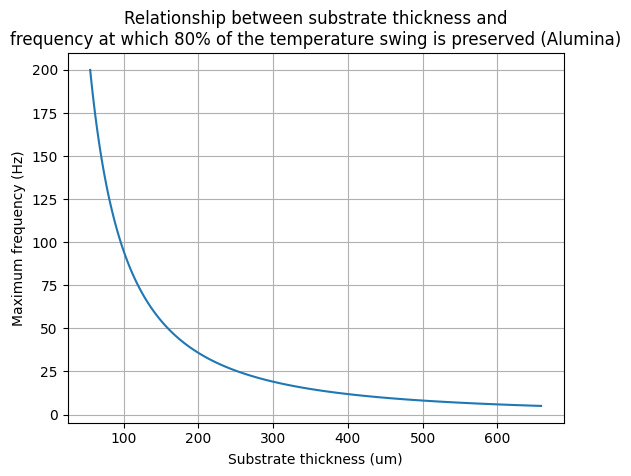

In [8]:
# make a plot of l vs trackable frequencies for Al2O3
# plotting 1/l forms a nearly straight line, with some higher-order effect at low l.
def plot_w_vs_l(N, ka, ks, rho_s, c_s, p):
    cutoff_amplitude = 0.8 # this is the amplitude where the sensed signal has 80% of the amplitude of the original.

    # intermediate vars
    beta = ks / (rho_s * c_s)
    m = ks * p / ka

    f_vals = np.logspace(np.log10(5), np.log10(200), 100)
    l_vals = []
    for f in f_vals:

        def g(l):
            solutions = get_eigenvalue_roots(N, m, l)
            def mu(n):
                return solutions[n-1]
            
            return cutoff_amplitude - attenuation_and_phase(mu, N, ka, ks, rho_s, c_s, p, l, 2*np.pi*f)[0]
        
        l_vals.append(root_scalar(g, bracket=[1e-6, 1e-2], method='brentq', xtol=1e-9)['root'])

    l_vals = np.array(l_vals)

    plt.plot(l_vals*1e6, f_vals)
    plt.xlabel("Substrate thickness (um)")
    plt.ylabel("Maximum frequency (Hz)")
    plt.title(f"Relationship between substrate thickness and\nfrequency at which 80% of the temperature swing is preserved (Alumina)")
    plt.grid(True)
    plt.show()

plot_w_vs_l(N=100, ka=3, ks=33, rho_s=3900, c_s=900, p=7.5e-6)

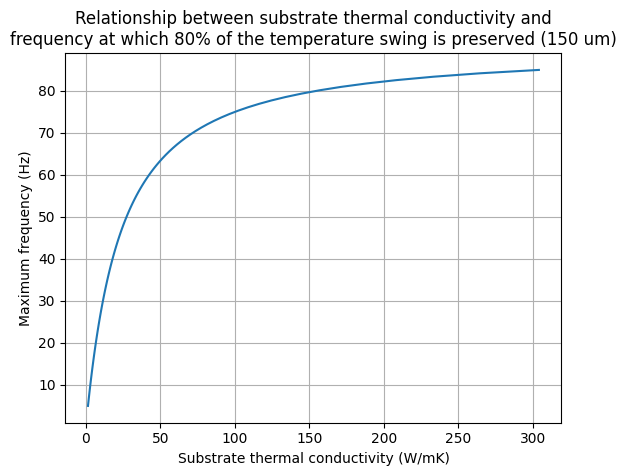

In [9]:
# make a plot of ks vs trackable frequencies for Al2O3
# this one forms a straight line when the adhesive is neglected
def plot_w_vs_ks(N, ka, l, rho_s, c_s, p):
    cutoff_amplitude = 0.8 # this is the amplitude where the sensed signal has 80% of the amplitude of the original.

    f_vals = np.linspace(5, 85, 100)
    ks_vals = []
    for f in f_vals:

        def g(ks):
            # intermediate vars
            beta = ks / (rho_s * c_s)
            m = ks * p / ka

            solutions = get_eigenvalue_roots(N, m, l)
            def mu(n):
                return solutions[n-1]
            
            return cutoff_amplitude - attenuation_and_phase(mu, N, ka, ks, rho_s, c_s, p, l, 2*np.pi*f)[0]
        
        ks_vals.append(root_scalar(g, bracket=[1e-5, 1e10], method='brentq', xtol=1e-2)['root'])

    ks_vals = np.array(ks_vals)

    plt.plot(ks_vals, f_vals)
    plt.xlabel("Substrate thermal conductivity (W/mK)")
    plt.ylabel("Maximum frequency (Hz)")
    plt.title(f"Relationship between substrate thermal conductivity and\nfrequency at which 80% of the temperature swing is preserved (150 um)")
    plt.grid(True)
    plt.show()

plot_w_vs_ks(N=30, ka=3, l=150e-6, rho_s=3900, c_s=900, p=7.5e-6)

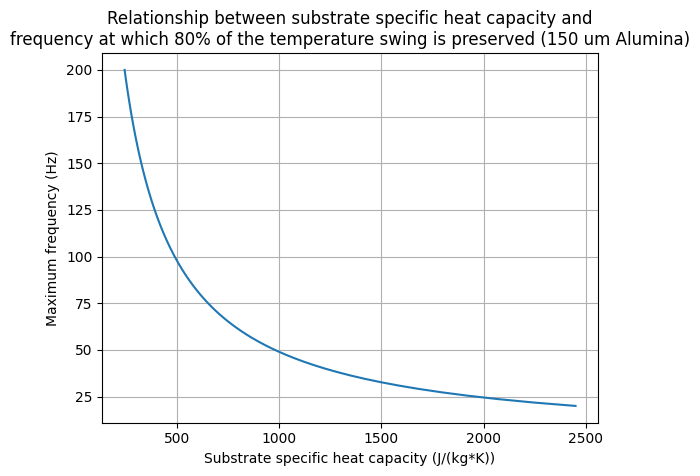

In [10]:
# make a plot of c_s vs trackable frequencies for Al2O3
# interestingly, the plot of 1/c_s vs trackable frequency is a straight line
def plot_w_vs_cs(N, ka, ks, l, rho_s, p):
    cutoff_amplitude = 0.8 # this is the amplitude where the sensed signal has 80% of the amplitude of the original.

    f_vals = np.linspace(20, 200, 100)
    cs_vals = []
    for f in f_vals:

        def g(c_s):
            # intermediate vars
            beta = ks / (rho_s * c_s)
            m = ks * p / ka

            solutions = get_eigenvalue_roots(N, m, l)
            def mu(n):
                return solutions[n-1]
            
            return cutoff_amplitude - attenuation_and_phase(mu, N, ka, ks, rho_s, c_s, p, l, 2*np.pi*f)[0]
        
        cs_vals.append(root_scalar(g, bracket=[1e-5, 1e10], method='brentq', xtol=1e-2)['root'])

    cs_vals = np.array(cs_vals)

    plt.plot(cs_vals, f_vals)
    plt.xlabel("Substrate specific heat capacity (J/(kg*K))")
    plt.ylabel("Maximum frequency (Hz)")
    plt.title(f"Relationship between substrate specific heat capacity and\nfrequency at which 80% of the temperature swing is preserved (150 um Alumina)")
    plt.grid(True)
    plt.show()

plot_w_vs_cs(N=30, ka=3, ks=33, l=150e-6, rho_s=3900, p=7.5e-6)

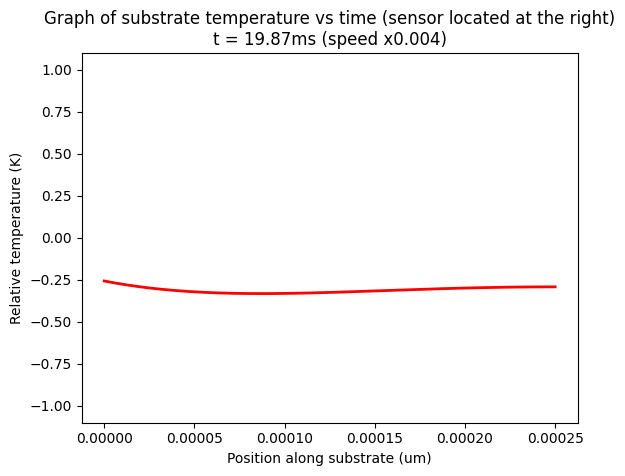

In [ ]:
# make a plot of u(x, t) over time
w = 100 * np.pi * 2
u = find_u(N, m, l, beta, w)

x = np.linspace(0, l, 200)
t_max = 2*2*np.pi/w
seconds = 5
fps = 30
speed = t_max / seconds
n_frames = seconds * fps

fig, ax = plt.subplots()
line, = ax.plot(x, u(x, 0), lw=2, color='red')
ax.set_ylim(-1.1, 1.1)
ax.set_xlabel('Position along substrate (um)')
ax.set_ylabel('Relative temperature (K)')

# Animation update function
def update(frame):
    t = (frame / fps) * speed  # Adjusted time with speed factor
    line.set_ydata(u(x, t))
    ax.set_title(f"Graph of substrate temperature vs time (sensor located at the right)\nt = {t*1000:.2f}ms (speed x{speed})")
    return line,

ani = FuncAnimation(fig, update, frames=int(n_frames), interval=1000/fps, blit=True)
HTML(ani.to_jshtml())